# Bahdanau Attention
we train two model with same hyperparameter
- The performance of the model is similar to that of Luong Attention with MLP method
- we set our hyperparameter as fellow:
    - single layer GRU
    - (both encoder and decoder) GRUhidden dim: 512
    - (both source and target)Word embedding dim: 256
    - Attentional hidden dim same as GRU hidden dim: 512
    - Dropout rate = 0.2
    - teacher forcing ratio = 0.5
- we found Bahdanau attention converges more quickly than Luong attention and overfitting problem is more severe

In [1]:
from dataset import Dataset

reverse_src = False
device = "cuda"
dataset = Dataset(reverse_src, device)

word_minq = 1
dataset.build_vocab(word_minq,word_minq)

src_vocab_size = len(dataset.srcField.vocab)
trg_vocab_size = len(dataset.trgField.vocab)
src_pad_idx = dataset.srcField.vocab.__getitem__(dataset.special_tokens['pad'])
trg_pad_idx = dataset.trgField.vocab.__getitem__(dataset.special_tokens['pad'])

In [2]:
from Bahdanau.models import Seq2Seq

model = Seq2Seq(src_vocab_size,trg_vocab_size,src_pad_idx,trg_pad_idx).to(device)

print(model.parameters)

/home/ljy/.conda/envs/long_NLP/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


<bound method Module.parameters of Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9796, 256, padding_idx=1)
    (rnn): GRU(256, 512, batch_first=True, dropout=0.2, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(18668, 256, padding_idx=1)
    (dropout): Dropout(p=0.2, inplace=False)
    (rnn): GRU(1280, 512, batch_first=True, dropout=0.2)
    (attention): Bahdanau_Attention(
      (W): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (fc_out): Linear(in_features=1792, out_features=18668, bias=True)
  )
)>


In [3]:
from Bahdanau.trainer import train
import torch

clip = 5
lr = 1e-2
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# optimizer = torch.optim.SGD(model.parameters(), lr)
optimizer = torch.optim.Adam(model.parameters())

train(model, optimizer, clip, dataset, 
      num_epochs=10, mini_batch_size=128, accum_iter=1,
      print_every=100)

model.save("Bahdanau02_E10.pt")

batch_size: 128
-----------------------------------------------------------------
Epoch 1
-----------------------------------------------------------------
[ 100/227 ] Loss: 4.575382... Val Loss: 4.902121... Val BLEU: 6.240662...
[ 200/227 ] Loss: 3.813009... Val Loss: 3.984441... Val BLEU: 18.606143...
[ 227/227 ] Loss: 3.356773... Val Loss: 3.850039... Val BLEU: 20.080068...
Total Epoche:  |    Time: 0m 33s
 Epoch Loss: 3.530562... Train BLEU: 19.977375...
-----------------------------------------------------------------
Epoch 2
-----------------------------------------------------------------
[ 100/227 ] Loss: 2.637981... Val Loss: 3.671196... Val BLEU: 23.476054...
[ 200/227 ] Loss: 2.814225... Val Loss: 3.515618... Val BLEU: 24.749772...
[ 227/227 ] Loss: 3.125818... Val Loss: 3.500863... Val BLEU: 25.764621...
Total Epoche:  |    Time: 0m 33s
 Epoch Loss: 2.703247... Train BLEU: 29.605570...
-----------------------------------------------------------------
Epoch 3
---------------

In [4]:
from Bahdanau.models import Seq2Seq

device = "cuda"

for i in range(1,3):
    exec(f"model{i} = Seq2Seq(src_vocab_size,trg_vocab_size,src_pad_idx,trg_pad_idx,build=False).to(device)")
    exec(f"model{i}.load('Bahdanau0{i}_E10.pt',device)")

/home/ljy/.conda/envs/long_NLP/lib/python3.8/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [5]:
batch_size = 128
train_iterator, val_iterator, test_iter = dataset.build_DataLoad(batch_size)

from Bahdanau.validator import evaluate

pad_idx = dataset.srcField.vocab.__getitem__(dataset.special_tokens['pad'])
bos_idx = dataset.srcField.vocab.__getitem__(dataset.special_tokens['bos'])
eos_idx = dataset.srcField.vocab.__getitem__(dataset.special_tokens['eos'])

for i in range(1,3):
    exec(f"test_loss{i}, BLEU_score{i} = evaluate(model{i}, test_iter, pad_idx, bos_idx, eos_idx, trgField=dataset.trgField, BLEU=True)")
    exec(f"print('Modle{i} Test set cost:',test_loss{i},'  |  Test set BLEU score:',BLEU_score{i})")

Modle1 Test set cost: 4.0601677894592285   |  Test set BLEU score: 28.49200665950775
Modle2 Test set cost: 4.05941104888916   |  Test set BLEU score: 29.616272449493408


source sentence         |  three young children stand around a blue and white barrel .
targe sentence          |  drei kleine kinder stehen um ein blau-weißes fass herum .
model1 predict sentence |  drei kinder stehen um eine blauen und weißen . <eos>
model2 predict sentence |  drei kleine kinder stehen um einen blauen und weißen . <eos>


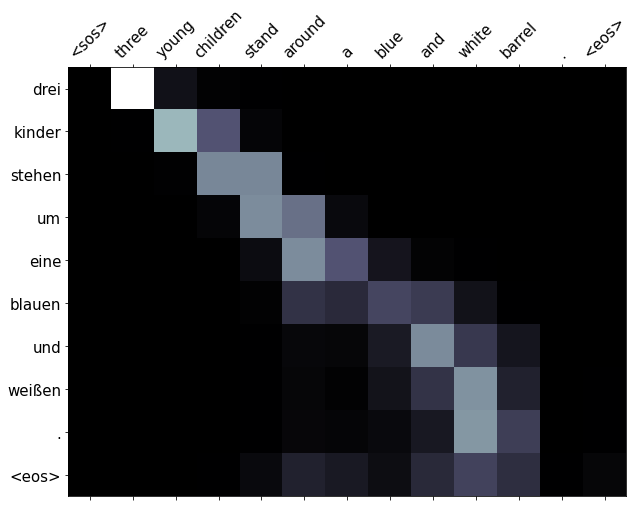

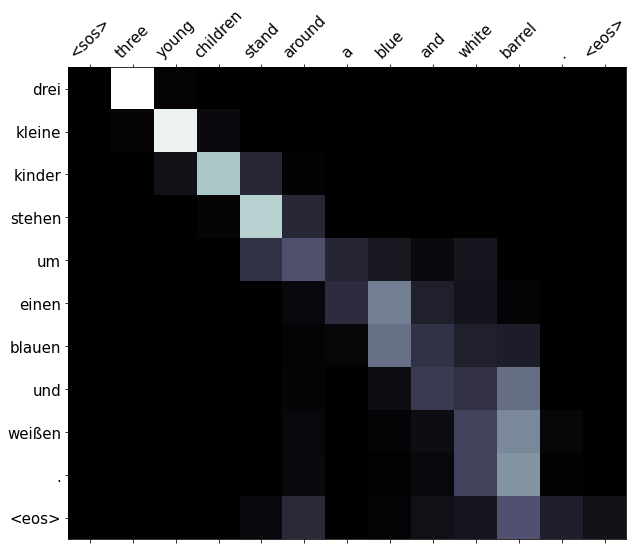

In [8]:
from Bahdanau.validator import single_decode
from Bahdanau.validator import display_attention

src = "three young children stand around a blue and white barrel ."
trg = "drei kleine kinder stehen um ein blau-weißes fass herum ."


print("source sentence         | ",src)
print("targe sentence          | ",trg)


for i in range(1,3):
    exec(f"src_sentence, translation{i}, atten_weights{i} = single_decode(model{i}, src, dataset, 'greedy')")
    exec(f"print('model{i} predict sentence |  '+' '.join(translation{i}))")
    
for i in range(1,3):
    exec(f"display_attention(src_sentence, translation{i}, atten_weights{i})")

source sentence         |  a little girl is holding a little boy on her lap .
targe sentence          |  ein kleines mädchen hält einen kleinen jungen auf ihrem schoß .
model1 predict sentence |  ein kleines mädchen hält einen kleinen jungen auf dem schoß . <eos>
model2 predict sentence |  ein kleines mädchen hält einen kleinen jungen auf dem schoß eines jungen . <eos>


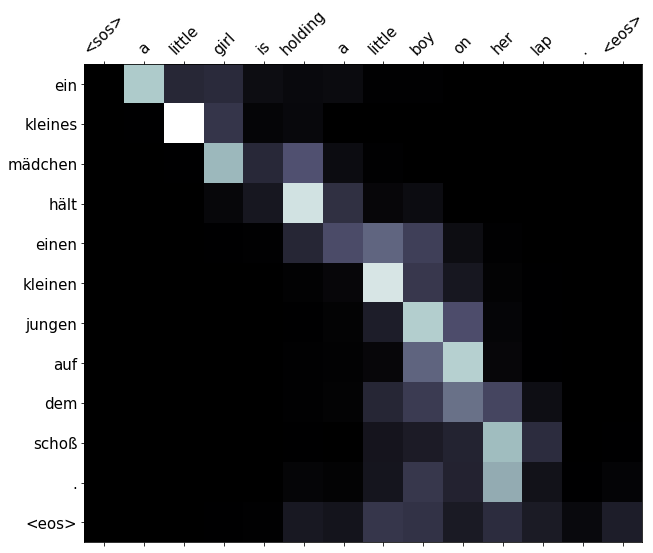

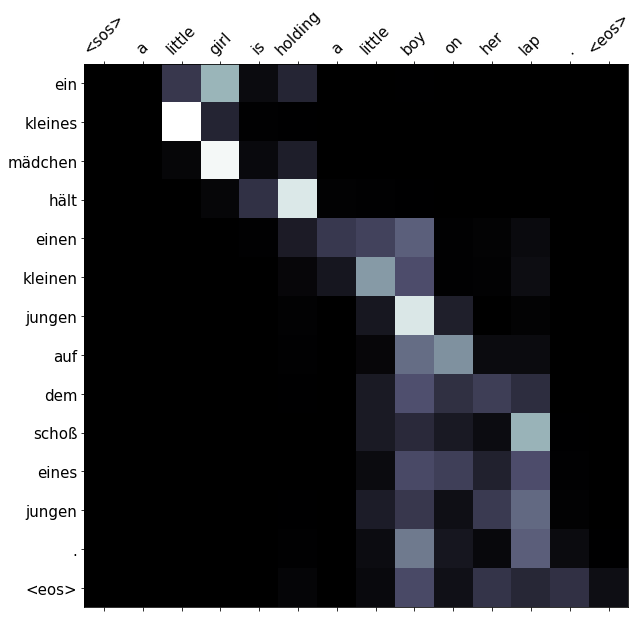

In [9]:
from Bahdanau.validator import single_decode
from Bahdanau.validator import display_attention

src = "a little girl is holding a little boy on her lap ."
trg = "ein kleines mädchen hält einen kleinen jungen auf ihrem schoß ."


print("source sentence         | ",src)
print("targe sentence          | ",trg)


for i in range(1,3):
    exec(f"src_sentence, translation{i}, atten_weights{i} = single_decode(model{i}, src, dataset, 'greedy')")
    exec(f"print('model{i} predict sentence |  '+' '.join(translation{i}))")
    
for i in range(1,3):
    exec(f"display_attention(src_sentence, translation{i}, atten_weights{i})")